In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import albumentations as A
import time
from torchvision import models
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.models as models
from tqdm import tqdm
from torchvision.utils import save_image

In [ ]:
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

In [ ]:
# !cp /content/DIV2K_train_HR.zip.1 /content/drive/MyDrive/
!unzip /content/drive/MyDrive/DIV2K_train_HR.zip.1 -d data/
!mkdir test_images
# import os
# len(os.listdir("/content/data/DIV2K_train_HR")) --> 800

# import cv2
# img = cv2.imread(os.path.join("/content/data/DIV2K_train_HR",os.listdir("/content/data/DIV2K_train_HR")[0]))
# img.shape --> (1356, 2040, 3)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,use_act,**kwargs):
        super(ConvBlock,self).__init__()
        self.use_act = use_act
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        if self.use_act:
          x = self.act(self.cnn(x))
        else:
          x = self.cnn(x)
        return x

class UpsampleBlock(nn.Module):
    def __init__(self, scale_factor,in_c):
        super(UpsampleBlock,self).__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor,mode="nearest")
        self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))

class ResDenseBlock(nn.Module):
    def __init__(self, in_channels,channels,lambda_res):
      super(ResDenseBlock,self).__init__()
      self.blocks = nn.ModuleList()
      self.lambda_res = lambda_res
      for i in range(5):
        self.blocks.append(ConvBlock(in_channels + channels*i,
                                     channels if i<4 else in_channels,
                                     use_act=True if i<4 else False,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1))

    def forward(self,x):
      in_x = x
      for block in self.blocks:
          out = block(in_x)
          in_x = torch.cat([in_x,out],dim=1)
      return (self.lambda_res*out) + x

class RRDBlock(nn.Module):
    def __init__(self, in_channels,lambda_res=0.2, channels=32):
        super(RRDBlock,self).__init__()
        self.rrdb_dense = nn.Sequential(*[ ResDenseBlock(in_channels,channels,lambda_res) for _ in range(3)])
        self.lambda_res = lambda_res

    def forward(self, x):
        out = self.rrdb_dense(x)
        return (self.lambda_res*out) + x

class Generator(nn.Module):
    def __init__(self, in_channels,num_channels=64,num_blocks=23,lambda_res=0.2):
        super(Generator,self).__init__()
        self.conv1 = ConvBlock(in_channels,num_channels,use_act=False,kernel_size=3,stride=1,padding=1)
        self.rrdb_block = nn.Sequential(*[RRDBlock(num_channels) for _ in range(num_blocks)])
        self.conv2 = ConvBlock(num_channels,num_channels,use_act=False,kernel_size=3,stride=1,padding=1)
        self.up_block = nn.Sequential(*[UpsampleBlock(2,num_channels) for _ in range(2)])
        self.conv3 = ConvBlock(num_channels,num_channels,use_act=True,kernel_size=3,stride=1,padding=1)
        self.conv4 = ConvBlock(num_channels,in_channels,use_act=False,kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        initial_x = self.conv1(x)
        x = self.conv2(self.rrdb_block(initial_x)) + initial_x
        x = self.up_block(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

def initialize_weights(model, scale=0.1):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale

        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale

In [ ]:
x = torch.rand((10,3,32,32))
gen = Generator(in_channels=3)
out = gen(x)
assert out.shape==(10,3,128,128)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    use_act=True,
                ),
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

# Config

In [ ]:
import torch
from PIL import Image
import albumentations as A
import os
from albumentations.pytorch import ToTensorV2

class Config:
  LOAD_MODEL = True
  SAVE_MODEL = True
  CHECKPOINT_GEN = "gen.pth"
  CHECKPOINT_DISC = "disc.pth"
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  LEARNING_RATE = 1e-4
  NUM_EPOCHS = 10000
  BATCH_SIZE = 16
  LAMBDA_GP = 10
  NUM_WORKERS = 4
  HIGH_RES = 128
  LOW_RES = HIGH_RES // 4
  IMG_CHANNELS = 3
  SAVED_PATH = "/content/saved"
  if not os.path.exists(SAVED_PATH):
    os.makedirs(SAVED_PATH)

  highres_transform = A.Compose(
      [
          A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
          ToTensorV2(),
      ]
  )

  lowres_transform = A.Compose(
      [
          A.Resize(width=LOW_RES, height=LOW_RES, interpolation=Image.BICUBIC),
          A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
          ToTensorV2(),
      ]
  )

  both_transforms = A.Compose(
      [
          A.RandomCrop(width=HIGH_RES, height=HIGH_RES),
          A.HorizontalFlip(p=0.5),
          A.RandomRotate90(p=0.5),
      ]
  )

  test_transform = A.Compose(
      [
          A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
          ToTensorV2(),
      ]
  )

config=Config()

# Utils

In [ ]:
import torch
import os
import numpy as np
from PIL import Image
from torchvision.utils import save_image

def gradient_penalty(critic, real, fake, device):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=config.DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def plot_examples(low_res_folder,saved_path, gen):
    files = os.listdir(low_res_folder)

    gen.eval()
    for file_name in files:
        image = Image.open(os.path.join(low_res_folder,file_name))
        with torch.no_grad():
            upscaled_img = gen(
                config.test_transform(image=np.asarray(image))["image"]
                .unsqueeze(0)
                .to(config.DEVICE)
            )
        save_image(upscaled_img, os.path.join(saved_path,file_name))
    gen.train()

# Dataset

In [ ]:
import torch
from tqdm import tqdm
import time
import torch.nn
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import cv2


class MyDataLoader(Dataset):
    def __init__(self, root_dir):
        super(MyDataLoader, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.data = os.listdir(root_dir)

        # for index, name in enumerate(self.class_names):
        #     files = os.listdir(os.path.join(root_dir, name))
        #     self.data += list(zip(files, [index] * len(files)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_file = self.data[index]
        image = cv2.imread(os.path.join(self.root_dir, img_file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        both_transform = config.both_transforms(image=image)["image"]
        low_res = config.lowres_transform(image=both_transform)["image"]
        high_res = config.highres_transform(image=both_transform)["image"]
        return low_res, high_res


# Training

In [ ]:
import torch.nn as nn
from torchvision.models import vgg19

class VGGLoss(nn.Module):
    def __init__(self,layer_no=35):
        super(VGGLoss,self).__init__()
        self.vgg = vgg19(pretrained=True).features[:layer_no].eval().to(config.DEVICE)

        for param in self.vgg.parameters():
            param.requires_grad = False

        self.loss = nn.MSELoss()

    def forward(self, input, target):
        return self.loss(self.vgg(input), self.vgg(target))

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

torch.backends.cudnn.benchmark = True

def train_fn(
    loader,
    disc,
    gen,
    opt_gen,
    opt_disc,
    l1,
    vgg_loss,
    g_scaler,
    d_scaler,
    writer,
    tb_step,
):
    loop = tqdm(loader, leave=True)

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(config.DEVICE)
        low_res = low_res.to(config.DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(low_res)
            critic_real = disc(high_res)
            critic_fake = disc(fake.detach())
            gp = gradient_penalty(disc, high_res, fake, device=config.DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + config.LAMBDA_GP * gp
            )

        opt_disc.zero_grad()
        d_scaler.scale(loss_critic).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        with torch.cuda.amp.autocast():
            l1_loss = 1e-2 * l1(fake, high_res)
            adversarial_loss = 5e-3 * -torch.mean(disc(fake))
            loss_for_vgg = vgg_loss(fake, high_res)
            gen_loss = l1_loss + loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        g_scaler.scale(gen_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        writer.add_scalar("Critic loss", loss_critic.item(), global_step=tb_step)
        tb_step += 1

        if idx % 25 == 0:
            plot_examples("test_images/",config.SAVED_PATH ,gen)

        loop.set_postfix(
            gp=gp.item(),
            critic=loss_critic.item(),
            l1=l1_loss.item(),
            vgg=loss_for_vgg.item(),
            adversarial=adversarial_loss.item(),
        )

    return tb_step


def main():
    dataset = MyDataLoader(root_dir="/content/data/DIV2K_train_HR")
    loader = DataLoader(
        dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        num_workers=config.NUM_WORKERS,
    )
    gen = Generator(in_channels=3).to(config.DEVICE)
    disc = Discriminator(in_channels=3).to(config.DEVICE)
    initialize_weights(gen)
    opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.9))
    opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.9))
    writer = SummaryWriter("logs")
    tb_step = 0
    l1 = nn.L1Loss()
    gen.train()
    disc.train()
    vgg_loss = VGGLoss()

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    if config.LOAD_MODEL:
        load_checkpoint(
            config.CHECKPOINT_GEN,
            gen,
            opt_gen,
            config.LEARNING_RATE,
        )
        load_checkpoint(
            config.CHECKPOINT_DISC,
            disc,
            opt_disc,
            config.LEARNING_RATE,
        )


    for epoch in range(config.NUM_EPOCHS):
        tb_step = train_fn(
            loader,
            disc,
            gen,
            opt_gen,
            opt_disc,
            l1,
            vgg_loss,
            g_scaler,
            d_scaler,
            writer,
            tb_step,
        )

        if config.SAVE_MODEL:
            save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=config.CHECKPOINT_DISC)

In [ ]:
try_model = False

if try_model:
    gen = Generator(in_channels=3).to(config.DEVICE)
    opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.9))
    load_checkpoint(
        config.CHECKPOINT_GEN,
        gen,
        opt_gen,
        config.LEARNING_RATE,
    )
    plot_examples("test_images/",config.SAVED_PATH, gen)
else:
    main()

In [ ]:
# !cp /content/disc.pth /content/drive/MyDrive/


Original image...



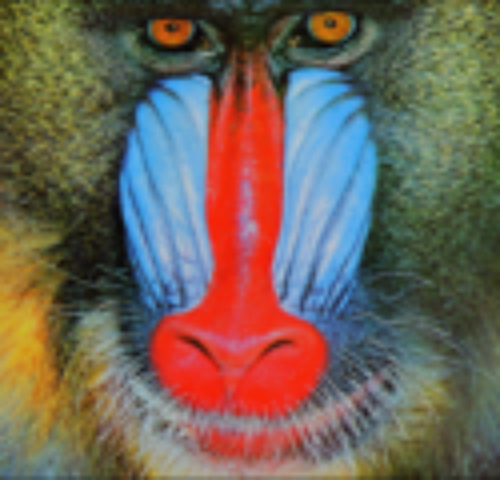


Enhanced Resolution...



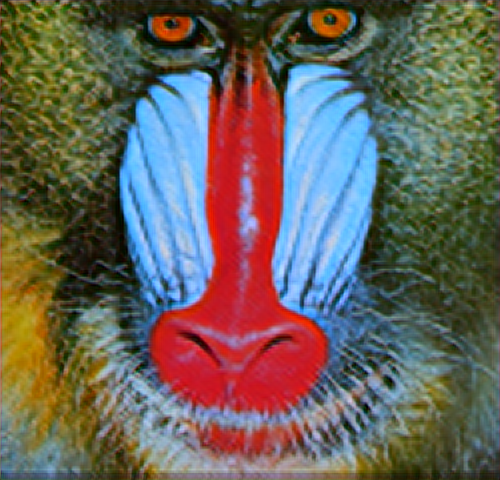

In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/test_images/baboon_LR.png")
print("\nOriginal image...\n")
cv2_imshow(cv2.resize(img,(500,480)))

from google.colab.patches import cv2_imshow
img = cv2.imread("/content/saved/baboon_LR.png")
print("\nEnhanced Resolution...\n")
cv2_imshow(img)